# TCS A&I
# Data Brew and Data Jam - Data Challenge (June 2020)

Team Memebers: Jeswanth Yadagani, Swarna Bharathi Mantena

Details: Both are Masters students at Columbia University

Github Repository Link: https://github.com/SwarnaBharathiMantena/Consumerism-Covid19

## Clustering

In [1]:
# Required imports

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default()) # for loading directly from the link

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# Get the dataset

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ZAagS3r0YcWxotqqHYpZbc0HdUJglb8NGbL6J23xiA0/edit?usp=sharing')
sheet = wb.worksheet('TCS_data264')
raw_data = sheet.get_all_values()
data_main = pd.DataFrame.from_records(raw_data[1:], columns=raw_data[0])
# data_main.head()


column_names = ['timestamp', 'consumerism', 'hear_survey', 'country_in', 'citystate_in', 'age_group', 'gender', 'race_enthnicity', #8
                'family_size', 'household_income_pa', 'education', 'profession', 'residence', 'pandemic_interpretation', 'new_normal', #15
                'expen_impt_food_groceries', 'expen_impt_healthcare', 'expen_impt_utilities', 'expen_impt_residence', 
                'expen_impt_education', 'expen_impt_entertainment', 'expen_impt_appliances', 'expen_impt_highvalue', 
                'expen_impt_business_expen', 'expen_impt_wellness', 'expen_impt_luxury', 'expen_impt_insurance', 
                'expen_impt_investments', 'expen_impt_other', #29
                'postcov_life_simplifier', 'postcov_degrowth_activist', 'postcov_climate_activist', 'postcov_sane_food', 
                'postcov_conservationist', 'postcov_remote_everything', 'postcov_most', 'postcov_little', 'postcov_no_change', 'postcov_other', #39
                'perspective_text', 'perspective_other', 'Email Address'] #42
data_main.columns = column_names
data_main = data_main[data_main.gender != 'Fish']
# data_main.head()


# missing data
data_main = data_main.replace('', np.nan)
# data_main.info()


data_main = data_main[data_main['consumerism'].notna()]
data_to_cluster = data_main[['country_in', 'age_group', 'gender', 'race_enthnicity', 'family_size', 'household_income_pa', 
                             'education', 'profession', 'residence', 
                             'pandemic_interpretation']]
# data_to_cluster.head()
data_to_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   country_in               260 non-null    object
 1   age_group                260 non-null    object
 2   gender                   261 non-null    object
 3   race_enthnicity          259 non-null    object
 4   family_size              259 non-null    object
 5   household_income_pa      246 non-null    object
 6   education                260 non-null    object
 7   profession               260 non-null    object
 8   residence                258 non-null    object
 9   pandemic_interpretation  258 non-null    object
dtypes: object(10)
memory usage: 22.4+ KB


In [3]:
def get_string_list(x):
    if type(x['pandemic_interpretation']) == str:
        split = x['pandemic_interpretation'].split(', ')
        if 'Family' in split:
            split.remove('Family')
            split.remove('friends and community come first')
            split.append('Family, friends and community come first')

        if 'More home cooking' in split:
            split.remove('More home cooking')
            split.remove('more kitchen gardening and less eating out')
            split.append('More home cooking more kitchen gardening and less eating out')

        if 'Have become more conscious of fragility of the planet' in split:
            split.remove('Have become more conscious of fragility of the planet')
            split.remove('of air and water pollution')
            split.append('Have become more conscious of fragility of the planet of air and water pollution')

        return split
    else:
        return []

data_to_cluster2 = data_to_cluster.copy()
string_list = data_to_cluster.apply(get_string_list, axis=1)
data_to_cluster2['pandemic_interpretation'] = string_list
# data_to_cluster2.head()


from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
data_to_cluster2 = data_to_cluster2.join(pd.DataFrame(mlb.fit_transform(data_to_cluster2.pop('pandemic_interpretation')),
                                                    columns=mlb.classes_,
                                                    index=data_to_cluster.index))
data_to_cluster2.head()

,country_in,age_group,gender,race_enthnicity,family_size,household_income_pa,education,profession,residence,"Family, friends and community come first",Have become more conscious of fragility of the planet of air and water pollution,Made me aware how fragile our health is,More home cooking more kitchen gardening and less eating out,Moving away from addiction to materialism and sensing other paths to a good life,Need to eat more healthy foods to have a greater resistance to germs and flus,Shocked by the inadequacy of our health systems and its great cost,The sudden loss of jobs will remain a trauma even after jobs come back,Will spend and save money more carefully
0,India,19 to 24,Female,Do not wish to disclose,Single,"Less than $24,999",Graduated from college,Employed in Private firm,town-home,0,1,1,1,0,1,1,0,0
1,India,19 to 24,Male,Do not wish to disclose,3-4,"$25,000 to $49,999",Graduated from college,Employed in Private firm,One to two bedroom apartment,1,0,1,1,1,1,1,1,1
2,India,19 to 24,Male,Asian / Pacific Islander,3-4,"Less than $24,999",Graduated from college,Student,3+ bedroom apartment,1,1,0,0,1,0,1,0,0
3,United States,19 to 24,Male,Asian / Pacific Islander,Single,"$100,000 to $149,999",Masters degree,Employed in Private firm,One to two bedroom apartment,1,0,1,1,0,1,1,0,0
4,India,19 to 24,Male,Do not wish to disclose,3-4,"Less than $24,999",Graduated from college,Seeking employment,One to two bedroom apartment,0,0,1,1,1,0,1,0,0


In [4]:
ohe_data_to_cluster = pd.get_dummies(data_to_cluster2[['country_in', 'age_group', 'gender', 'race_enthnicity', 
                                                       'family_size', 'household_income_pa', 
                                                        'education', 'profession', 'residence'
                                                     ]])
data_to_cluster2 = pd.concat([data_to_cluster2.drop(['country_in', 'age_group', 'gender', 'country_in', 
                                                     'race_enthnicity', 'family_size', 'household_income_pa', 
                                                      'education', 'profession', 'residence' 
                                                    ], axis=1), ohe_data_to_cluster], axis=1)
data_to_cluster2.head()

,"Family, friends and community come first",Have become more conscious of fragility of the planet of air and water pollution,Made me aware how fragile our health is,More home cooking more kitchen gardening and less eating out,Moving away from addiction to materialism and sensing other paths to a good life,Need to eat more healthy foods to have a greater resistance to germs and flus,Shocked by the inadequacy of our health systems and its great cost,The sudden loss of jobs will remain a trauma even after jobs come back,Will spend and save money more carefully,country_in_Australia,country_in_Canada,country_in_Germany,country_in_Hungary,country_in_India,country_in_Ireland,country_in_Other (Please specify),country_in_Qatar,country_in_Sweden,country_in_United Arab Emirates,country_in_United Kingdom,country_in_United States,age_group_19 to 24,age_group_25 to 34,age_group_35 to 44,age_group_45 to 54,age_group_55 to 64,age_group_65 to 74,age_group_75 or older,age_group_Do not wish to disclose,age_group_Less than 18,gender_Female,gender_Male,gender_Prefer not to say,race_enthnicity_American Indian or Alaskan Native,race_enthnicity_Asian / Pacific Islander,race_enthnicity_Do not wish to disclose,race_enthnicity_Hindu,race_enthnicity_Indian,race_enthnicity_Indian from India.,family_size_1,...,"household_income_pa_$150,000 or More","household_income_pa_$25,000 to $49,999","household_income_pa_$50,000 to $74,999","household_income_pa_$75,000 to $99,999",household_income_pa_0,household_income_pa_Currently a student,household_income_pa_Do not wish to disclose,household_income_pa_IDk,"household_income_pa_Less than $24,999",household_income_pa_Prefer not to say,education_Doctorate,education_Double graduation,education_Engineering,education_Graduated from college,education_High school,education_I f**ked up,education_Masters degree,education_Post Grad,education_Under graduate,profession_Employed in Private firm,profession_Employed in Public or Government firm,profession_Home maker,profession_Own Business - Small & Medium,profession_Retired,profession_Seeking employment,profession_Self employed Professional,profession_Student,residence_3+ bedroom apartment,residence_Bungalow,residence_Castle/Chateau/Palace/Cottage/Ranch/etc,residence_Condominium,residence_Hostel,residence_I live in jungle,residence_One to two bedroom apartment,residence_PG,residence_Row House,residence_Single family (detached),residence_Studio apartment,residence_sharing,residence_town-home
0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [5]:
def get_clustering_information(K, data):
    silhouette_scores = []
    ch_scores = []
    y_hats = []
    for k in K:
        k_means = KMeans(n_clusters=k, random_state=2**20)
        model = k_means.fit(data)
        y_hat = k_means.predict(data)
        y_hats.append(y_hat)
        # silhouette coefficient
        labels = k_means.labels_
        silhouette_scores.append(metrics.silhouette_score(data_to_cluster2, labels, metric = 'euclidean'))
        # CH score
        ch_scores.append(metrics.calinski_harabasz_score(data_to_cluster2, labels))

    return y_hats, silhouette_scores, ch_scores

def plot_graph(X, y, title, xlabel, ylabel, need_log_x, lab):
    plt.plot(X, y, label=lab)
    if (need_log_x == 1):
        plt.xscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if lab:
        plt.legend()

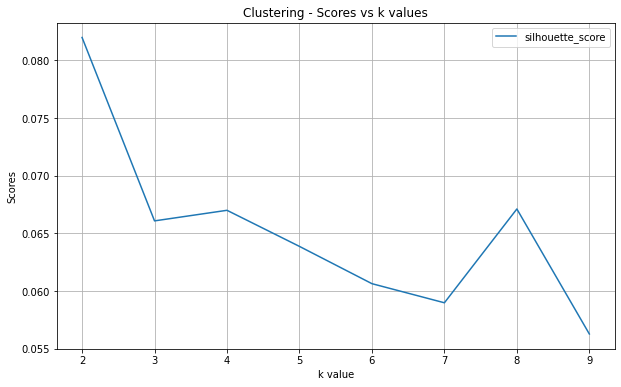

In [6]:
K = list(range(2, 10))
y_hats, silhouette_scores, ch_scores = get_clustering_information(K, data_to_cluster2)

plt.figure(figsize=(10, 6))
plot_graph(K, silhouette_scores, 'Clustering - Scores vs k values', 'k value', 'Scores', 0, 'silhouette_score')

In [7]:
silhouette_dict = {'documentID': 'silhouette_scores'}
for k, v in zip(K, silhouette_scores):
    silhouette_dict[str(k)] = v

In [8]:
# Code specific to our MongoDB Atlas set up
# This has to be modified when the code is tried to reproduce
!pip install pymongo
!pip install dnspython

# from pymongo import MongoClient 
# db = MongoClient("<your_API_key>").<details>

# # db.plots #table handler
# db.plots.insert_one(silhouette_dict) # to upload 
# # db.plots.delete_one(silhouette_dict) # to delete

In [9]:
silhouette_dict
# db.plots.insert_one(silhouette_dict)

{'2': 0.08198568680246478,
 '3': 0.0660791621480063,
 '4': 0.06699683654777754,
 '5': 0.06386612240217335,
 '6': 0.06063434184755356,
 '7': 0.058976877094586454,
 '8': 0.06711140736214714,
 '9': 0.05627157471497517,
 'documentID': 'silhouette_scores'}

As 2 clusters has the best silhouette score, we proceed with dividing the respondants into two categories.

The Silhouette Index measures the distance between each data point, the centroid of the cluster it was assigned to and the closest centroid belonging to another cluster.

In [10]:
data_modified = data_main.drop(['timestamp', 'hear_survey', 'citystate_in', 'race_enthnicity', 
                                'pandemic_interpretation', 'perspective_other', 'Email Address'], axis=1)
# data_modified.columns


def get_string_list_newn(x):
    if type(x['new_normal']) == str:
        split = x['new_normal'].split(', ')
        if 'Enhanced rigor in personal wellness' in split:
            split.remove('Enhanced rigor in personal wellness')
            split.remove('safety & hygiene')
            split.append('Enhanced rigor in personal wellness, safety & hygiene')

        if 'More virtual-socializing like family video chats' in split:
            split.remove('More virtual-socializing like family video chats')
            split.remove('functions')
            split.remove('etc?')
            split.append('More virtual-socializing like family video chats, functions, etc?')

        if 'Remote ‘everything’ – education' in split:
            split.remove('Remote ‘everything’ – education')
            split.remove('healthcare')
            split.remove('financial services')
            split.remove('entertainment & …. so on ?')
            split.append('Remote ‘everything’ – education, healthcare, financial services, entertainment & …. so on ?')

        if 'Near term distress for certain sectors ? - Aviation & Travel | Business real estate | Events like sports' in split:
            split.remove('Near term distress for certain sectors ? - Aviation & Travel | Business real estate | Events like sports')
            split.remove('concerts | etc')
            split.append('Near term distress for certain sectors ? - Aviation & Travel | Business real estate | Events like sports, concerts | etc')

        return split
    else:
        return []



data_modified2 = data_modified.copy()
string_list_newn = data_modified2.apply(get_string_list_newn, axis=1)
data_modified2['new_normal'] = string_list_newn
data_modified2.head()


,consumerism,country_in,age_group,gender,family_size,household_income_pa,education,profession,residence,new_normal,expen_impt_food_groceries,expen_impt_healthcare,expen_impt_utilities,expen_impt_residence,expen_impt_education,expen_impt_entertainment,expen_impt_appliances,expen_impt_highvalue,expen_impt_business_expen,expen_impt_wellness,expen_impt_luxury,expen_impt_insurance,expen_impt_investments,expen_impt_other,postcov_life_simplifier,postcov_degrowth_activist,postcov_climate_activist,postcov_sane_food,postcov_conservationist,postcov_remote_everything,postcov_most,postcov_little,postcov_no_change,postcov_other,perspective_text
0,"No, never heard them before",India,19 to 24,Female,Single,"Less than $24,999",Graduated from college,Employed in Private firm,town-home,[Practicing more physical distancing habits in...,Cannot Say,Increase Slightly,Increase Slightly,Remain Constant,Remain Constant,Reduced Slightly,Increase Slightly,Reduced Significantly,Remain Constant,Increase Slightly,Remain Constant,Increase Slightly,Increase Slightly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lightly Agree,NaN,NaN,NaN,Lot of unnecessary spendings are scraped out. ...
1,Yes but only aware of the terms,India,19 to 24,Male,3-4,"$25,000 to $49,999",Graduated from college,Employed in Private firm,One to two bedroom apartment,[Practicing more physical distancing habits in...,Remain Constant,Remain Constant,Increase Slightly,Remain Constant,Remain Constant,Reduced Significantly,Reduced Slightly,Remain Constant,Remain Constant,Remain Constant,Reduced Slightly,Increase Slightly,Increase Slightly,Cannot Say,Neither Agree nor Disagree,Lightly Disagree,Strongly Agree,Lightly Agree,Lightly Agree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,NaN
2,"No, never heard them before",India,19 to 24,Male,3-4,"Less than $24,999",Graduated from college,Student,3+ bedroom apartment,[Practicing more physical distancing habits in...,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Increase Slightly,Remain Constant,Remain Constant,Remain Constant,Cannot Say,Neither Agree nor Disagree,Neither Agree nor Disagree,Strongly Agree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,NaN
3,"No, never heard them before",United States,19 to 24,Male,Single,"$100,000 to $149,999",Masters degree,Employed in Private firm,One to two bedroom apartment,[Practicing more physical distancing habits in...,Increase Significantly,Cannot Say,Remain Constant,Remain Constant,Remain Constant,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Remain Constant,Increase Slightly,Remain Constant,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,NaN
4,Yes but only aware of the terms,India,19 to 24,Male,3-4,"Less than $24,999",Graduated from college,Seeking employment,One to two bedroom apartment,"[More e-learning ?, Economic depression & degr...",Increase Slightly,Remain Constant,Increase Significantly,Remain Constant,Remain Constant,Reduced Significantly,Reduced Slightly,Reduced Significantly,Reduced Significantly,Reduced Slightly,Reduced Significantly,Remain Constant,Increase Slightly,NaN,Lightly Disagree,Strongly Disagree,Strongly Agree,Lightly Disagree,Lightly Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Lightly Disagree,Lightly Disagree,NaN,NaN


In [11]:
mlb = MultiLabelBinarizer()
data_modified2 = data_modified2.join(pd.DataFrame(mlb.fit_transform(data_modified2.pop('new_normal')),
                                                    columns=mlb.classes_,
                                                    index=data_to_cluster.index))
# data_modified2.columns


data_to_cluster3 = data_to_cluster2[['Family, friends and community come first',
                      'Have become more conscious of fragility of the planet of air and water pollution',
                      'Made me aware how fragile our health is',
                      'More home cooking more kitchen gardening and less eating out',
                      'Moving away from addiction to materialism and sensing other paths to a good life',
                      'Need to eat more healthy foods to have a greater resistance to germs and flus',
                      'Shocked by the inadequacy of our health systems and its great cost',
                      'The sudden loss of jobs will remain a trauma even after jobs come back',
                      'Will spend and save money more carefully']]

data_modified3 = pd.concat([data_modified2, data_to_cluster3], axis=1)
# data_modified3.columns  

## Understanding the clusters' features

In [12]:
def get_dict(df, documentID):
    dictt = {}
    df = df.round(2)
    dictt['labels'] = df.index.tolist()
    dictt['A'] = df['cluster_0'].values.tolist()
    dictt['B'] = df['cluster_1'].values.tolist()
    dictt['documentID'] = documentID
    return dictt

In [13]:
indices_0 = [i for i, e in enumerate(y_hats[0]) if e == 0]
indices_1 = [i for i, e in enumerate(y_hats[0]) if e == 1]

data_0 = data_modified3.iloc[indices_0]
data_1 = data_modified3.iloc[indices_1]

pi_data_0 = data_to_cluster3.iloc[indices_0]
pi_data_1 = data_to_cluster3.iloc[indices_1]

In [14]:
pi0 = pi_data_0.mean(axis=0) #= 'cluster_0'
pi0 = pi0.rename("cluster_0")
pi0

pi1 = pi_data_1.mean(axis=0) #= 'cluster_0'
pi1 = pi1.rename("cluster_1")
# pi1

personal_interpretation_df = pd.concat([pi0, pi1], axis=1)
# personal_interpretation_df = personal_interpretation_df.round(2)
# personal_interpretation_df

personal_interpretation_dict = get_dict(personal_interpretation_df, 'personal_interpretation')
personal_interpretation_dict

{'A': [0.66, 0.44, 0.58, 0.63, 0.31, 0.61, 0.57, 0.4, 0.45],
 'B': [0.58, 0.49, 0.58, 0.57, 0.51, 0.63, 0.57, 0.48, 0.56],
 'documentID': 'personal_interpretation',
 'labels': ['Family, friends and community come first',
  'Have become more conscious of fragility of the planet of air and water pollution',
  'Made me aware how fragile our health is',
  'More home cooking more kitchen gardening and less eating out',
  'Moving away from addiction to materialism and sensing other paths to a good life',
  'Need to eat more healthy foods to have a greater resistance to germs and flus',
  'Shocked by the inadequacy of our health systems and its great cost',
  'The sudden loss of jobs will remain a trauma even after jobs come back',
  'Will spend and save money more carefully']}

In [15]:
# # Additional Informaiton
## to delete one table
# query = {'documentID': 'persoanl_interpretation'}
# db.plots.delete_one(query) 
## to delete all
# db.plots.delete_many({})

In [16]:
# load to mongodb
# db.plots.insert_one(personal_interpretation_dict)

In [17]:
consumerism_df = pd.concat([data_0['consumerism'].value_counts(normalize=True) * 100, data_1['consumerism'].value_counts(normalize=True) * 100], axis=1)
consumerism_df.columns = ['cluster_0', 'cluster_1']
# consumerism_df

consumerism_dict = get_dict(consumerism_df, 'consumerism')
consumerism_dict

{'A': [47.06, 36.13, 16.81],
 'B': [51.41, 35.21, 13.38],
 'documentID': 'consumerism',
 'labels': ['No, never heard them before',
  'Yes but only aware of the terms',
  'Yes and I actively practice some principles of Anti Consumerism/Post Consumerism']}

In [18]:
# load to mongodb
# db.plots.insert_one(consumerism_dict)

In [19]:
gender_df = pd.concat([data_0['gender'].value_counts(normalize=True) * 100, data_1['gender'].value_counts(normalize=True) * 100], axis=1)
gender_df.columns = ['cluster_0', 'cluster_1']
gender_df = gender_df.fillna(0)
# gender_df

gender_dict = get_dict(gender_df, 'gender')
gender_dict

{'A': [63.03, 36.97, 0.0],
 'B': [60.56, 38.73, 0.7],
 'documentID': 'gender',
 'labels': ['Male', 'Female', 'Prefer not to say']}

In [20]:
# load to mongodb
# db.plots.insert_one(gender_dict)

In [21]:
country_df = pd.concat([data_0['country_in'].value_counts(normalize=True) * 100, data_1['country_in'].value_counts(normalize=True) * 100], axis=1)
country_df.columns = ['cluster_0', 'cluster_1']
country_df = country_df.fillna(0)
# country_df

country_dict = get_dict(country_df, 'country')
country_dict

{'A': [47.06, 39.5, 4.2, 2.52, 1.68, 1.68, 0.84, 0.84, 0.84, 0.84, 0.0, 0.0],
 'B': [5.67, 90.78, 0.0, 0.0, 0.0, 1.42, 0.0, 0.0, 0.0, 0.0, 1.42, 0.71],
 'documentID': 'country',
 'labels': ['United States',
  'India',
  'Canada',
  'United Kingdom',
  'Sweden',
  'United Arab Emirates',
  'Hungary',
  'Ireland',
  'Germany',
  'Other (Please specify)',
  'Australia',
  'Qatar']}

In [22]:
# load to mongodb
# db.plots.insert_one(country_dict)

In [23]:
education_df = pd.concat([data_0['education'].value_counts(normalize=True) * 100, data_1['education'].value_counts(normalize=True) * 100], axis=1)
education_df.columns = ['cluster_0', 'cluster_1']
education_df = education_df.fillna(0)
# education_df

# delete
education_df = education_df[education_df.index != 'I  f**ked up']
education_df = education_df[education_df.index != 'Engineering']

education_dict = get_dict(education_df, 'education')
education_dict

{'A': [83.05, 5.93, 5.08, 2.54, 0.85, 0.85, 0.0],
 'B': [1.41, 84.51, 0.7, 12.68, 0.0, 0.0, 0.7],
 'documentID': 'education',
 'labels': ['Masters degree',
  'Graduated from college',
  'Doctorate',
  'High school',
  'Post Grad',
  'Double graduation',
  'Under graduate']}

In [24]:
# load to mongodb
# db.plots.insert_one(education_dict)

In [25]:
profession_df = pd.concat([data_0['profession'].value_counts(normalize=True) * 100, data_1['profession'].value_counts(normalize=True) * 100], axis=1)
profession_df.columns = ['cluster_0', 'cluster_1']
profession_df = profession_df.fillna(0)
# profession_df

profession_dict = get_dict(profession_df, 'profession')
profession_dict

{'A': [55.93, 21.19, 8.47, 7.63, 2.54, 2.54, 1.69, 0.0],
 'B': [45.77, 30.99, 6.34, 3.52, 2.11, 6.34, 2.82, 2.11],
 'documentID': 'profession',
 'labels': ['Employed in Private firm',
  'Student',
  'Seeking employment',
  'Employed in Public or Government firm',
  'Own Business - Small & Medium',
  'Retired',
  'Self employed Professional',
  'Home maker']}

In [26]:
# load to mongodb
# db.plots.insert_one(profession_dict)

In [27]:
residence_df = pd.concat([data_0['residence'].value_counts(normalize=True) * 100, data_1['residence'].value_counts(normalize=True) * 100], axis=1)
residence_df.columns = ['cluster_0', 'cluster_1']
residence_df = residence_df.fillna(0)
# residence_df

# delete
residence_df = residence_df[residence_df.index != 'I live in jungle']

residence_dict = get_dict(residence_df, 'residence')
residence_dict

{'A': [37.93, 30.17, 9.48, 7.76, 5.17, 5.17, 1.72, 0.86, 0.86, 0.0, 0.0, 0.0],
 'B': [59.86, 11.97, 10.56, 5.63, 3.52, 6.34, 0.0, 0.0, 0.0, 0.7, 0.7, 0.7],
 'documentID': 'residence',
 'labels': ['One to two bedroom apartment',
  '3+ bedroom apartment',
  'Single family (detached)',
  'town-home',
  'Studio apartment',
  'Bungalow',
  'Condominium',
  'Row House',
  'sharing',
  'PG',
  'Hostel',
  'Castle/Chateau/Palace/Cottage/Ranch/etc']}

In [28]:
# load to mongodb
# db.plots.insert_one(residence_dict)

In [29]:
household_income_pa_df = pd.concat([data_0['household_income_pa'].value_counts(normalize=True) * 100, data_1['household_income_pa'].value_counts(normalize=True) * 100], axis=1)
household_income_pa_df.columns = ['cluster_0', 'cluster_1']
household_income_pa_df = household_income_pa_df.fillna(0)
# household_income_pa_df

# delete
household_income_pa_df = household_income_pa_df[household_income_pa_df.index != 'IDk']
household_income_pa_df = household_income_pa_df[household_income_pa_df.index != 'Currently a student']
household_income_pa_df = household_income_pa_df[household_income_pa_df.index != '0']
household_income_pa_df = household_income_pa_df[household_income_pa_df.index != 'Prefer not to say']
household_income_pa_df = household_income_pa_df[household_income_pa_df.index != 'Do not wish to disclose']


household_income_pa_dict = get_dict(household_income_pa_df, 'household_income_pa')
household_income_pa_dict

{'A': [24.14, 22.41, 15.52, 12.93, 12.93, 8.62],
 'B': [70.77, 2.31, 3.08, 3.08, 0.77, 19.23],
 'documentID': 'household_income_pa',
 'labels': ['Less than $24,999',
  '$75,000 to $99,999',
  '$50,000 to $74,999',
  '$100,000 to $149,999',
  '$150,000 or More',
  '$25,000 to $49,999']}

In [30]:
# load to mongodb
# db.plots.insert_one(household_income_pa_dict)

# Exploring their choices further

In [31]:
# Growth in Anti-Consumerism behavior ?
nn0 = data_0[data_0.columns[34:45].tolist()] # new normal
nn1 = data_1[data_1.columns[34:45].tolist()]


growth_anticon_df = pd.concat([nn0.iloc[:, 2].value_counts(normalize=True) * 100, nn1.iloc[:, 2].value_counts(normalize=True) * 100], axis=1)
growth_anticon_df.columns = ['cluster_0', 'cluster_1']
growth_anticon_df.index = ['No growth in anti-consumerism', 'Growth in anti-consumerism']
# growth_anticon_df

growth_anticon_dict = get_dict(growth_anticon_df, 'growth_anticon')
growth_anticon_dict

{'A': [77.31, 22.69],
 'B': [80.28, 19.72],
 'documentID': 'growth_anticon',
 'labels': ['No growth in anti-consumerism', 'Growth in anti-consumerism']}

In [32]:
# load to mongodb
# db.plots.insert_one(growth_anticon_dict)

In [33]:
# Remote ‘everything’ – education, healthcare, financial services, entertainment & …. so on ?
remote_everything_df = pd.concat([nn0.iloc[:, 10].value_counts(normalize=True) * 100, nn1.iloc[:, 10].value_counts(normalize=True) * 100], axis=1)
remote_everything_df.columns = ['cluster_0', 'cluster_1']
remote_everything_df.index = ['Disagree', 'Agree']
# remote_everything_df

remote_everything_dict = get_dict(remote_everything_df, 'remote_everything')
remote_everything_dict

{'A': [57.14, 42.86],
 'B': [67.61, 32.39],
 'documentID': 'remote_everything',
 'labels': ['Disagree', 'Agree']}

In [34]:
# load to mongodb
# db.plots.insert_one(remote_everything_dict)

## Industries - opinion on expenditure

In [35]:
def get_exp_score(data):
    score = 0
    num = len(data)
    counts = data.value_counts()
    score = score + ( 2 * counts['Increase Significantly'] ) + ( 1 * counts['Increase Slightly'] ) 
    score = score + ( -2 * counts['Reduced Significantly'] ) + ( -1 * counts['Reduced Slightly'] )
    # score = score + ( 0 * counts['Remain Constant'] ) + ( 0 * counts['Cannot Say'] )
    return round(float(score/num), 2)

def get_exp_dict(col_name, docID):
    dictt = {}
    dictt['documentID'] = docID
    dictt['cluster_0'] = get_exp_score(data_0[col_name])
    dictt['cluster_1'] = get_exp_score(data_1[col_name])
    dictt['label'] = 'score'
    return dictt

In [36]:
# data_0, data_1
# format: get_exp_dict(col_name, docID)

# 1. Banks - Investment
banks = get_exp_dict('expen_impt_investments', 'exp_banks')

# 2. Capital Goods - Business expenditure
capital_goods = get_exp_dict('expen_impt_business_expen', 'exp_capital_goods')

# 3. Consumer Apparel - Luxury goods expenditure
consumer_apparel = get_exp_dict('expen_impt_luxury', 'exp_consumer_apparel')

# 4. Food and Staples Retailing - food and groceries
food = get_exp_dict('expen_impt_food_groceries', 'exp_food')

# 5. Health Care Pharmaceuticals - healthcare, Wellness expenditure
health = {}
health['documentID'] = 'health'
health['cluster_0'] = round(float((get_exp_score(data_0['expen_impt_healthcare']) + get_exp_score(data_0['expen_impt_wellness']))/2), 2)
health['cluster_1'] = round(float((get_exp_score(data_1['expen_impt_healthcare']) + get_exp_score(data_1['expen_impt_wellness']))/2), 2)
health['label'] = 'score'
# health

# 6. Insurance - insurance expenditure
insurance = get_exp_dict('expen_impt_insurance', 'exp_insurance')

# 7. Media Entertainment - entertainment expenditure
entertainment = get_exp_dict('expen_impt_entertainment', 'exp_entertainment')

# 8. Education 
education = get_exp_dict('expen_impt_education', 'exp_education')

# 9. Real Estate - Residence expenditure
realestate = get_exp_dict('expen_impt_residence', 'exp_realestate')

# 10. Technology Goods Products - Appliances and Electronics expenditure
technology = get_exp_dict('expen_impt_appliances', 'exp_technology')

# # 11. E-commerce Online service platforms - e-commerce, online, work from home - scale 0 to 1
# for this we collected data in a diff format, so it is either agree or disagree overall - average score
ecomm0 = ( float(data_0['More e-commerce and online shopping ?'].sum()/len(data_0['More e-commerce and online shopping ?']))
         + float(data_0['More e-learning ?'].sum()/len(data_0['More e-learning ?']))
         + float(data_0['More adoption of work from home culture?'].sum()/len(data_0['More adoption of work from home culture?']))
         + float(data_0['More adoption of Digital Technology into daily lifestyle ?'].sum()/len(data_0['More adoption of Digital Technology into daily lifestyle ?']))
          ) / 4
ecomm1 = ( float(data_1['More e-commerce and online shopping ?'].sum()/len(data_1['More e-commerce and online shopping ?']))
         + float(data_1['More e-learning ?'].sum()/len(data_1['More e-learning ?']))
         + float(data_1['More adoption of work from home culture?'].sum()/len(data_1['More adoption of work from home culture?']))
         + float(data_1['More adoption of Digital Technology into daily lifestyle ?'].sum()/len(data_1['More adoption of Digital Technology into daily lifestyle ?']))
          ) / 4
ecommerce = {}
ecommerce['documentID'] = 'ecommerce'
ecommerce['cluster_0'] = ecomm0
ecommerce['cluster_1'] = ecomm1
ecommerce['label'] = 'score'
# ecommerce

In [37]:
# scale e-commerce from 0-1 to -2to2
def get_scaled_value(x):
# -2 a +2
#  0 x 1
    return round((4 * x) - 2, 2)


ecommerce['cluster_0'] = get_scaled_value(ecommerce['cluster_0'])
ecommerce['cluster_1'] = get_scaled_value(ecommerce['cluster_1'])
ecommerce

{'cluster_0': 0.54,
 'cluster_1': 0.27,
 'documentID': 'ecommerce',
 'label': 'score'}

## Cluster opinion across industries

In [38]:
indust_labels = ['Banks', 'Capital Goods', 'Consumer Apparel', 'Food and Staples Retailing', 'Health Care and Pharmaceuticals', 
              'Insurance', 'Media and Entertainment', 'Education', 'Real Estate', 'Technology Products', 'Online Service Platforms']
industries_list = [banks, capital_goods, consumer_apparel, food, health, insurance, 
                   entertainment, education, realestate, technology, ecommerce]

indust_scores0 = []
indust_scores1 = []
for entry in industries_list:
    indust_scores0.append(entry['cluster_0'])
    indust_scores1.append(entry['cluster_1'])

industry_scores = {}
industry_scores['documentID'] = 'industry_scores'
industry_scores['labels'] = indust_labels
industry_scores['A'] = indust_scores0
industry_scores['B'] = indust_scores1
industry_scores

{'A': [0.32, -0.66, -0.92, 0.1, -0.27, 0.12, -0.99, 0.01, -0.03, -0.29, 0.54],
 'B': [0.04,
  -0.66,
  -0.97,
  -0.05,
  -0.28,
  0.22,
  -1.02,
  -0.01,
  -0.11,
  -0.32,
  0.27],
 'documentID': 'industry_scores',
 'labels': ['Banks',
  'Capital Goods',
  'Consumer Apparel',
  'Food and Staples Retailing',
  'Health Care and Pharmaceuticals',
  'Insurance',
  'Media and Entertainment',
  'Education',
  'Real Estate',
  'Technology Products',
  'Online Service Platforms']}

In [39]:
# db.plots.insert_one(industry_scores)

## Post-consumerist post COVID 19

What kind of Post-consumerist do you think you may become Post COVID-19?

In [40]:
def get_postcov_score(data):
    score = 0
    num = len(data)
    counts = data.value_counts()
    score = score + ( 2 * counts['Strongly Agree'] ) + ( 1 * counts['Lightly Agree'] ) 
    score = score + ( -2 * counts['Strongly Disagree'] ) + ( -1 * counts['Lightly Disagree'] )
    # score = score + ( 0 * counts['Neither Agree nor Disagre'] ) + ( 0 * counts[nan] )
    return round(float(score/num), 3)


postcov_labels = ['Life Simplifier', 'De-growth Activist', 'Climate Activist', 'Sane Food Chooser', 'Conservationist', 'Remote everything']
postcov_list = ['postcov_life_simplifier', 'postcov_degrowth_activist', 'postcov_climate_activist', 
                'postcov_sane_food', 'postcov_conservationist', 'postcov_remote_everything']

postcov_scores0 = []
postcov_scores1 = []
for entry in postcov_list:
    postcov_scores0.append(get_postcov_score(data_0[entry]))
    postcov_scores1.append(get_postcov_score(data_1[entry]))


postcov_scores = {}
postcov_scores['documentID'] = 'postcov_scores'
postcov_scores['labels'] = postcov_labels
postcov_scores['A'] = postcov_scores0
postcov_scores['B'] = postcov_scores1
postcov_scores

{'A': [0.731, 0.706, 1.252, 0.454, 0.798, 0.622],
 'B': [0.577, 0.627, 1.268, 0.493, 0.725, 0.408],
 'documentID': 'postcov_scores',
 'labels': ['Life Simplifier',
  'De-growth Activist',
  'Climate Activist',
  'Sane Food Chooser',
  'Conservationist',
  'Remote everything']}

In [41]:
# db.plots.insert_one(postcov_scores)

In [42]:
# 'postcov_most', 'postcov_little', 'postcov_no_change'
postcov2_labels = ['Most of everything', 'Little of everything', 'Back to usual self']
postcov2_list = ['postcov_most', 'postcov_little', 'postcov_no_change']

postcov2_scores0 = []
postcov2_scores1 = []
for entry in postcov2_list:
    postcov2_scores0.append(get_postcov_score(data_0[entry]))
    postcov2_scores1.append(get_postcov_score(data_1[entry]))


postcov2_scores = {}
postcov2_scores['documentID'] = 'postcov_scores_2'
postcov2_scores['labels'] = postcov2_labels
postcov2_scores['A'] = postcov2_scores0
postcov2_scores['B'] = postcov2_scores1
postcov2_scores

{'A': [0.529, 0.319, -0.361],
 'B': [0.514, 0.394, -0.106],
 'documentID': 'postcov_scores_2',
 'labels': ['Most of everything',
  'Little of everything',
  'Back to usual self']}

In [43]:
# db.plots.insert_one(postcov2_scores)

References:

https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca